# Chapter 10: Synthetic Control
## Causal Inference: The Mixtape → CausalPy

**Mixtape chapter**: [Synthetic Control](https://mixtape.scunning.com/10-synthetic_control)

**CausalPy method**: `SyntheticControl`

---

### Overview

Synthetic control is a method for estimating causal effects in comparative case studies where a single treated unit is compared to a weighted combination of control units. The key idea is to construct a "synthetic" control that closely matches the treated unit's pre-intervention trajectory.

This notebook covers the **Texas prison reform** example from Cunningham (2021), which examines the effect of prison capacity expansion on incarceration rates.

### What we'll cover

1. Data preparation for synthetic control
2. CausalPy `SyntheticControl` estimation
3. Visualizing the synthetic vs actual treated unit
4. Donor weights and pre-treatment fit
5. Treatment effect estimation

### Mixtape files implemented

| File | Description | Status |
|------|-------------|--------|
| `synth_1.py` | Texas SC basic implementation | ✅ |
| `synth_2.py` | Texas SC - treatment effect plot | ✅ |
| `synth_3_7.py` | Placebo tests | ⏭️ (empty in original) |


## Setup


In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import causalpy as cp

# Add the src directory to path for our data utilities
import sys

sys.path.insert(0, "../src")
from mixtape_causalpy import load_texas

%matplotlib inline


## Load and Explore Data

The Texas dataset contains state-level panel data on incarceration rates (`bmprison` - black male prison admission rate) and various predictors across US states from 1985-2000.

### The Texas Prison Expansion

In 1993, Texas dramatically expanded prison capacity. The synthetic control method allows us to estimate what incarceration rates *would have been* in Texas without this policy change, by constructing a weighted combination of other states that matched Texas's pre-1993 trajectory.

Key variables:
- **`statefip`**: State FIPS code (48 = Texas)
- **`year`**: Year (1985-2000)
- **`bmprison`**: Black male prison admission rate per 100,000
- **`state`**: State name


In [2]:
# Load the data
df_raw = load_texas()
print(f"Dataset shape: {df_raw.shape}")
print(f"Years: {df_raw['year'].min()} to {df_raw['year'].max()}")
print(f"States: {df_raw['statefip'].nunique()}")
df_raw.head()


Dataset shape: (816, 24)
Years: 1985.0 to 2000.0
States: 51


,statefip,year,race,bmprison,wmprison,bmpop,wmpop,error,crack,alcohol,...,perc1519,aidscapita,state,parole,probation,capacity_rated,capacity_operational,capacity_design,bmprate,wmprate
0,1.0,1985.0,2.0,6227.0,4210.0,464428,1427743,0.0,0.217438,1.90,...,8.461768,0.679504,Alabama,2425.0,16520,9787.0,9787.0,9787.0,1340.789062,294.871002
1,1.0,1986.0,1.0,6657.0,4423.0,465387,1434773,0.0,0.276875,1.90,...,8.473580,0.851692,Alabama,3038.0,21371,10374.0,10374.0,10374.0,1430.422363,308.271759
2,1.0,1987.0,1.0,7281.0,4803.0,467545,1442894,0.0,0.211371,1.89,...,8.397089,1.967214,Alabama,3456.0,23406,11107.0,11107.0,11107.0,1557.283203,332.872681
3,1.0,1988.0,1.0,7244.0,4605.0,468281,1445048,0.0,0.559781,1.89,...,8.280076,2.758137,Alabama,4701.0,25301,11162.0,11162.0,11162.0,1546.934448,318.674530
4,1.0,1989.0,1.0,8056.0,4998.0,468893,1445678,0.0,0.721824,1.87,...,8.088959,3.845907,Alabama,5724.0,25519,11162.0,11662.0,11662.0,1718.089233,345.720154


In [3]:
# Check Texas (statefip=48) data
texas_data = df_raw[df_raw["statefip"] == 48][["year", "state", "bmprison"]]
print("Texas incarceration data:")
print(texas_data)


Texas incarceration data:
       year  state  bmprison
688  1985.0  Texas   14828.0
689  1986.0  Texas   15207.0
690  1987.0  Texas   15780.0
691  1988.0  Texas   16956.0
692  1989.0  Texas   19366.0
693  1990.0  Texas   22634.0
694  1991.0  Texas   23249.0
695  1992.0  Texas   27568.0
696  1993.0  Texas   29260.0
697  1994.0  Texas   40451.0
698  1995.0  Texas   55602.0
699  1996.0  Texas   55810.0
700  1997.0  Texas   58393.0
701  1998.0  Texas   59709.0
702  1999.0  Texas   60785.0
703  2000.0  Texas   61861.0


## Prepare Data for CausalPy

CausalPy's `SyntheticControl` expects data in a wide format where:
- Each row is a time period
- Each column is a unit (state)
- The index is the time variable

We need to reshape the panel data from long to wide format.


In [4]:
# Pivot to wide format: rows=years, columns=states
df_wide = df_raw.pivot(index="year", columns="state", values="bmprison")

# Clean column names (remove spaces/special chars for easier access)
df_wide.columns = [col.strip() for col in df_wide.columns]

print(f"Wide format shape: {df_wide.shape}")
print(f"Columns (states): {list(df_wide.columns[:10])}...")  # First 10
df_wide.head()


Wide format shape: (16, 51)
Columns (states): ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida']...


,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
year,,,,,,,,,,,,,,,,,,,,,
1985.0,6227.0,198.0,1297.0,2153.0,16138.0,665.0,2620.0,1356.0,6021.0,13427.0,...,21.0,3045.0,14828.0,142.0,0.0,6825.0,1218.0,244.0,1954.0,33.0
1986.0,6657.0,211.0,1452.0,2238.0,19549.0,786.0,2890.0,1545.0,6241.0,15486.0,...,28.0,3000.0,15207.0,143.0,0.0,7291.0,1182.0,201.0,2136.0,32.0
1987.0,7281.0,217.0,1675.0,2536.0,22184.0,959.0,3070.0,1595.0,7126.0,16074.0,...,24.0,3019.0,15780.0,161.0,0.0,7488.0,1129.0,200.0,2234.0,30.0
1988.0,7244.0,271.0,1775.0,2646.0,26438.0,1229.0,3541.0,1823.0,8205.0,17510.0,...,28.0,2972.0,16956.0,167.0,0.0,8239.0,1225.0,199.0,2244.0,52.0
1989.0,8056.0,310.0,2033.0,3126.0,30066.0,1492.0,4172.0,2045.0,9320.0,20750.0,...,32.0,4364.0,19366.0,196.0,0.0,9739.0,1315.0,211.0,2501.0,51.0


In [5]:
# Define treated unit and control units (donor pool)
treated_unit = "Texas"
treatment_time = 1993  # Year of prison capacity expansion

# Get all states except Texas as potential donors
all_states = list(df_wide.columns)
control_units = [s for s in all_states if s != treated_unit]

print(f"Treated unit: {treated_unit}")
print(f"Treatment time: {treatment_time}")
print(f"Number of control units: {len(control_units)}")
print(f"Control units: {control_units[:5]}... (showing first 5)")


Treated unit: Texas
Treatment time: 1993
Number of control units: 50
Control units: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California']... (showing first 5)


## Visualize Pre-Treatment Trends

Before running synthetic control, let's visualize Texas compared to some control states.


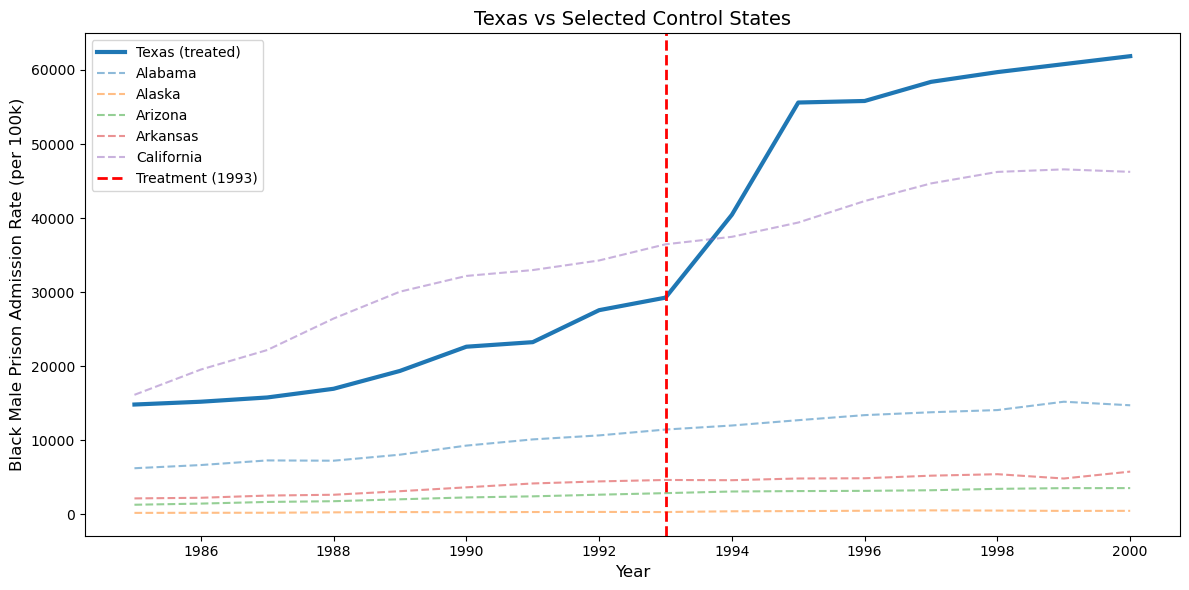

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Texas
ax.plot(
    df_wide.index,
    df_wide[treated_unit],
    linewidth=3,
    color="C0",
    label="Texas (treated)",
)

# Plot a few control states for comparison
sample_controls = control_units[:5]
for state in sample_controls:
    ax.plot(df_wide.index, df_wide[state], alpha=0.5, linestyle="--", label=state)

# Add treatment time line
ax.axvline(
    x=treatment_time,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Treatment ({treatment_time})",
)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Black Male Prison Admission Rate (per 100k)", fontsize=12)
ax.set_title("Texas vs Selected Control States", fontsize=14)
ax.legend(loc="upper left", fontsize=10)

plt.tight_layout()
plt.show()


## CausalPy Synthetic Control Analysis

Now we use CausalPy's `SyntheticControl` to estimate the treatment effect. CausalPy will:

1. Find optimal weights for donor states that best match Texas pre-1993
2. Construct the synthetic Texas using these weights
3. Compare actual Texas to synthetic Texas post-1993


In [7]:
# Run Synthetic Control with CausalPy
# Note: cores=1 for macOS Jupyter compatibility
result = cp.SyntheticControl(
    df_wide,
    treatment_time,
    control_units=control_units,
    treated_units=[treated_unit],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={
            "tune": 1000,
            "draws": 1000,
            "chains": 2,
            "cores": 1,  # Single core for macOS Jupyter
            "target_accept": 0.95,
            "progressbar": True,
        }
    ),
)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [8]:
# View the summary
result.summary()


================================SyntheticControl================================
Control units: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Treated unit: Texas
Model coefficients:
    Alabama               0.00044, 94% HDI [1.7e-05, 0.0015]
    Alaska                0.00025, 94% HDI [7.9e-06, 0.00087]
    Arizona               0.00028, 94% HDI [1e-05, 0.00097]
    Arkansas              0.00032, 94% HDI 

## Visualize Results

CausalPy provides a built-in plot showing the actual treated unit vs the synthetic control.


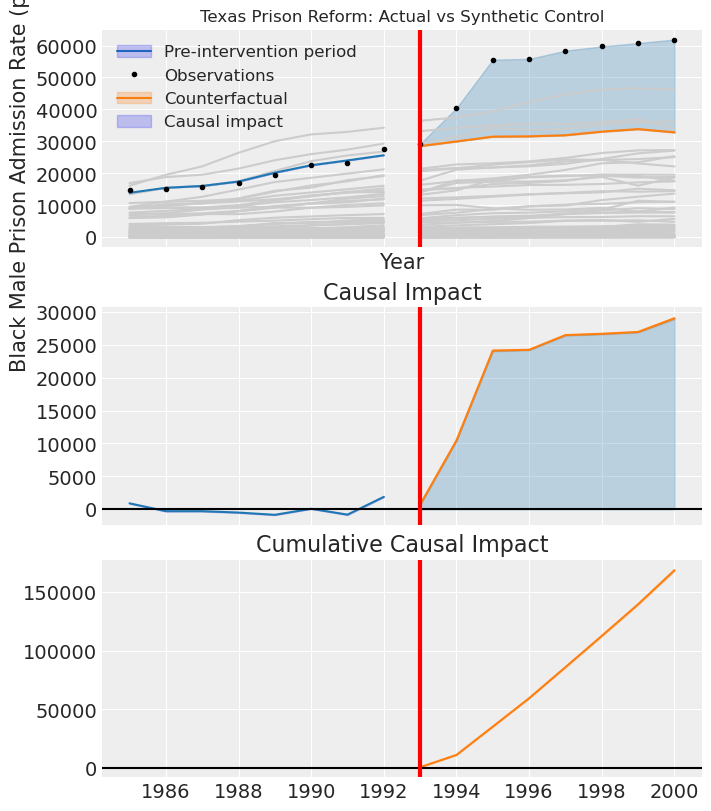

In [9]:
# Plot the synthetic control results
fig, ax = result.plot(plot_predictors=True)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Black Male Prison Admission Rate (per 100k)")
ax[0].set_title("Texas Prison Reform: Actual vs Synthetic Control")
plt.show()


## Donor Weights

Which states contribute most to the synthetic Texas? The weights tell us which states are most similar to Texas in the pre-treatment period.


In [10]:
# Extract posterior mean weights
beta = result.idata.posterior["beta"]
weights_mean = beta.mean(dim=["chain", "draw"]).values.flatten()

# Create a dataframe of weights
weights_df = pd.DataFrame({"state": control_units, "weight": weights_mean}).sort_values(
    "weight", ascending=False
)

# Show top contributing states
print("Top 10 Donor Weights:")
print(weights_df.head(10).to_string(index=False))


Top 10 Donor Weights:
     state   weight
   Florida 0.383998
  New York 0.361930
  Illinois 0.237204
      Ohio 0.001022
California 0.000699
 Louisiana 0.000695
  Michigan 0.000655
  Maryland 0.000639
   Georgia 0.000598
  Virginia 0.000579


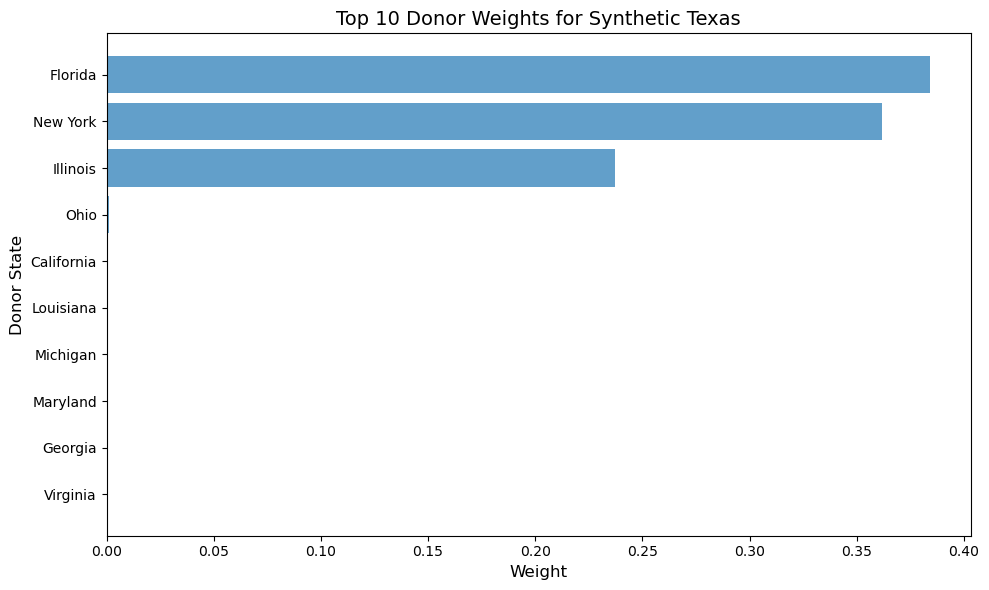

In [11]:
# Visualize top weights
top_n = 10
top_weights = weights_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_weights["state"], top_weights["weight"], color="C0", alpha=0.7)
ax.set_xlabel("Weight", fontsize=12)
ax.set_ylabel("Donor State", fontsize=12)
ax.set_title(f"Top {top_n} Donor Weights for Synthetic Texas", fontsize=14)
ax.invert_yaxis()  # Highest weight at top

plt.tight_layout()
plt.show()


## Treatment Effect (Gap Plot)

The treatment effect is the difference between actual Texas and synthetic Texas. This "gap plot" shows the causal effect over time.


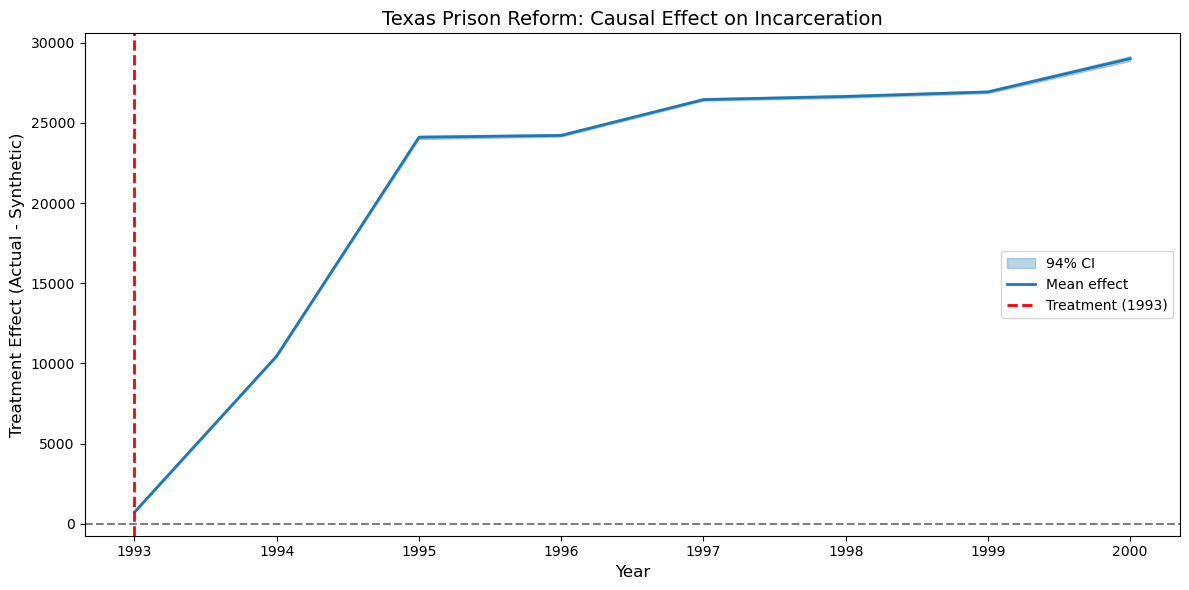

In [12]:
# Get the post-treatment impact
post_impact = result.post_impact

# Plot the gap (treatment effect over time)
fig, ax = plt.subplots(figsize=(12, 6))

# Get posterior mean for the impact
impact_mean = post_impact.mean(dim=["chain", "draw"]).values.flatten()

# Get HDI using percentiles directly
impact_lower = post_impact.quantile(0.03, dim=["chain", "draw"]).values.flatten()
impact_upper = post_impact.quantile(0.97, dim=["chain", "draw"]).values.flatten()

years_post = result.datapost.index.values

# Plot mean impact with uncertainty
ax.fill_between(
    years_post,
    impact_lower,
    impact_upper,
    alpha=0.3,
    color="C0",
    label="94% CI",
)
ax.plot(years_post, impact_mean, color="C0", linewidth=2, label="Mean effect")

# Add zero line
ax.axhline(y=0, color="black", linestyle="--", alpha=0.5)

# Add treatment time
ax.axvline(
    x=treatment_time,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Treatment ({treatment_time})",
)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Treatment Effect (Actual - Synthetic)", fontsize=12)
ax.set_title("Texas Prison Reform: Causal Effect on Incarceration", fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()


## Effect Summary

CausalPy provides a convenient `effect_summary()` method for decision-ready reporting.


In [13]:
# Generate effect summary
stats = result.effect_summary(treated_unit=treated_unit)
print(stats.text)


Post-period (1993.0 to 2000.0), the average effect was 21070.01 (95% HDI [20983.47, 21148.18]), with a posterior probability of an increase of 1.000. The cumulative effect was 168560.06 (95% HDI [167867.77, 169185.45]); probability of an increase 1.000. Relative to the counterfactual, this equals 66.54% on average (95% HDI [66.09%, 66.95%]).


In [14]:
# View the summary table
stats.table


,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,21070.007206,21068.968807,20983.470759,21148.181214,1.0,66.543043,66.08883,66.954936
cumulative,168560.057651,168551.750458,167867.766069,169185.449709,1.0,66.543043,66.08883,66.954936


## Comparison to Mixtape Results

### Key Findings

The Mixtape's synthetic control analysis of Texas shows:

1. **Pre-treatment fit**: Synthetic Texas closely matches actual Texas before 1993
2. **Post-treatment divergence**: After prison expansion, Texas incarceration rates diverged
3. **Positive treatment effect**: Prison expansion led to higher incarceration rates

### Differences from Book's Implementation

| Aspect | Mixtape | CausalPy |
|--------|---------|----------|
| Package | R's `Synth` via rpy2 | Pure Python (PyMC) |
| Estimation | Optimization-based | Bayesian (MCMC) |
| Inference | Point estimates | Full posterior distributions |
| Covariates | Multiple predictors | Outcome matching only |


## Summary

This notebook demonstrated:

1. **Data preparation** for synthetic control (long → wide format)
2. **CausalPy's `SyntheticControl`** for Bayesian estimation
3. **Visualizing results**: actual vs synthetic, treatment effects
4. **Donor weights**: which states contribute to synthetic Texas
5. **Effect summaries**: average and cumulative causal impacts

The key finding replicates the Mixtape: Texas's prison capacity expansion in 1993 caused a significant increase in black male incarceration rates compared to what would have occurred without the policy.


---

## References

- **Mixtape chapter**: [Chapter 10: Synthetic Control](https://mixtape.scunning.com/10-synthetic_control)
- **CausalPy documentation**: [https://causalpy.readthedocs.io/](https://causalpy.readthedocs.io/)
- **Original paper**: Abadie, A., Diamond, A., & Hainmueller, J. (2010). Synthetic Control Methods for Comparative Case Studies. *Journal of the American Statistical Association*, 105(490), 493-505.


## Comparison to Mixtape Results

### Key Findings

The Mixtape's synthetic control analysis of Texas shows:

1. **Pre-treatment fit**: Synthetic Texas closely matches actual Texas before 1993
2. **Post-treatment divergence**: After prison expansion, Texas incarceration rates diverged significantly from the synthetic control
3. **Positive treatment effect**: The prison expansion led to *higher* incarceration rates than would have occurred otherwise

### Differences from Book's Implementation

| Aspect | Mixtape | CausalPy |
|--------|---------|----------|
| Package | R's `Synth` via rpy2 | Pure Python (PyMC) |
| Estimation | Optimization-based | Bayesian (MCMC) |
| Inference | Point estimates | Full posterior distributions |
| Covariates | Multiple predictors | Outcome matching only |
| Uncertainty | Limited | Credible intervals |

### Key Differences

1. **Bayesian approach**: CausalPy provides full uncertainty quantification via posterior distributions
2. **Predictor matching**: The original Mixtape uses multiple covariates (poverty, income, etc.) for matching; CausalPy's basic version matches on outcome trajectory only
3. **Weights interpretation**: CausalPy weights are posterior means with uncertainty; Mixtape weights are point estimates
